**Laboratório de Inovação e Automação 1 (LIA 1) - Atividade Modelo 2 (11/12)**

---

**ALUNO:** Samuel França da Costa Pedrosa

**MATRÍCULA:** 201900261

---



# **RNN (LSTM) PARA PREVER SÉRIE TEMPORAL**
---

O último modelo foi utilizado Convolutional Neural Network que é um tipo de Redes Neurais Profundas apropriado para imagens e a base de dados foi a Cifar10 do TensorFlow. Como um outro exemplo de modelo, utilizei uma base de dados de série temporal e outro tipo de rede neural profunda apropriada para esses tipos de dados, o Recurrent Neural Network, especificamente o LSTM (Long Short-Term Memory).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Base de Dados**

* A base de dados que será utilizada como série temporal são registros de requisições de uber em 2014 na cidade de Nova York, contendo a data, horário e localização e uma base com código do tipo de viagem. Os dados estão compartilhados no kaggle pelo [link](https://https://www.kaggle.com/datasets/fivethirtyeight/uber-pickups-in-new-york-city).

In [36]:
database = pd.DataFrame()
for i in range(10):
  url = 'https://raw.githubusercontent.com/sampedrosa/sampedrosa/main/ubert_data/uber_data_pt' + str(i) + '.csv'
  uber_data = pd.read_csv(url)
  database = pd.concat([database, uber_data], ignore_index=True)
database

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
4534322,9/30/2014 22:57:00,40.7668,-73.9845,B02764
4534323,9/30/2014 22:57:00,40.6911,-74.1773,B02764
4534324,9/30/2014 22:58:00,40.8519,-73.9319,B02764
4534325,9/30/2014 22:58:00,40.7081,-74.0066,B02764


*  Como uma série temporal, é necessário adicionar um atributo com o tempo percorrido, nesse caso em horas.

In [38]:
dataset = database.copy()
dataset['Date/Time'] = pd.to_datetime(dataset['Date/Time'], format='%m/%d/%Y %H:%M:%S')
dataset = dataset.sort_values(by='Date/Time').reset_index(drop=True)
first = pd.to_datetime(dataset['Date/Time'][0], format='%m/%d/%Y %H:%M:%S')
dataset['Hours'] = (dataset['Date/Time'] - first).dt.total_seconds()/3600.0
dataset.head()

,Date/Time,Lat,Lon,Base,Hours
0,2014-04-01 00:00:00,40.7188,-73.9863,B02598,0.000000
1,2014-04-01 00:00:00,40.7215,-73.9952,B02682,0.000000
2,2014-04-01 00:00:00,40.7637,-73.9600,B02598,0.000000
3,2014-04-01 00:01:00,40.7355,-73.9966,B02617,0.016667
4,2014-04-01 00:02:00,40.7184,-73.9601,B02682,0.033333


# **Análise dos Dados**

*  Uma análise visual informativa é agrupar a base de dados por minuto do dia e somar a quantidade de pedidos que teve.

<Axes: xlabel='Hours'>

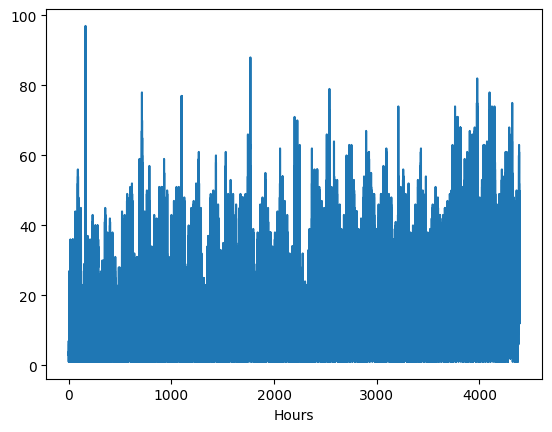

In [ ]:
sns.lineplot(x=dataset.groupby('Hours').size().index, y=dataset.groupby('Hours').size().values)

*  É compreensível que essa série temporal será afetada pelo horário do dia e pelo dia da semana. Ou seja, há dois tipos de sazonalidade.

In [ ]:
count_hours, count_weeks = [], []
for hour in dataset['Hours']:
  count_hours.append(int(hour % 24.0))
  count_weeks.append(int(int(hour % 24.0) % 7))

total_days = max(dataset['Hours'])/24
count_hours = np.unique(count_hours, return_counts=True)
count_weeks = np.unique(count_weeks, return_counts=True)

* Relação com o dia.

<Axes: >

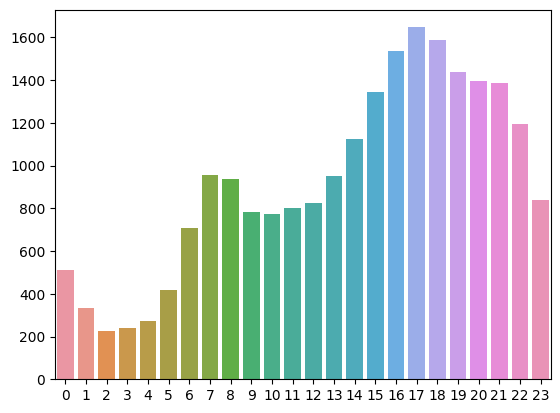

In [ ]:
sns.barplot(x=count_hours[0], y=(count_hours[1]/total_days))

* Relação com a semana.

<Axes: >

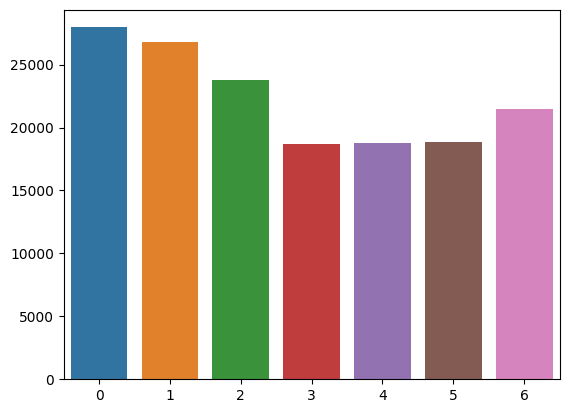

In [ ]:
sns.barplot(x=count_weeks[0], y=(count_weeks[1]/26))

# **Tratamento dos Dados**

* Precisamos tabelar os dados importantes transformando-os em Requisições por Minuto e a Próxima contagem.

In [ ]:
request = dataset.groupby('Hours').size().values
request = list(request)
next_request = request.copy()

request.pop()
next_request.pop(0)

data = pd.DataFrame({'Request': request, 'Next Request': next_request})
data.index.name = 'Minute'
data.head()

,Request,Next Request
Minute,,
0,3,1
1,1,3
2,3,2
3,2,1
4,1,1


# **Formatação e Treinamento do Modelo**

*  Declaração de variáveis:

In [ ]:
train_ptg = 0.9 # porcentagem do treino
lookback = 1    # recuo do dado que será analisado
neurons = 32    # quantidade de neurônios do LSTM
ep = 8          # epochs, repetições dos processos

*  Para transformar as features e targets em dados que podem ser usados pelo LSTM:
  *   Transformação do tipo (float32).
  *   Transformação vetorial (array).
  *   Transformação vertical (reshape).
  *   Transformação escalar (scaler).
  *   Definir parte de treino e teste.
  *   Definir os atributos em [samples, lookback, features]



In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = np.array(request).astype('float32').reshape(-1,1)
y = np.array(next_request).astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

train_size = int(len(X)*train_ptg)
test_size = len(X) - train_size
X_train = np.array(X[0:train_size,:])
X_test = np.array(X[train_size:len(X),:])
y_train = np.array(y[0:train_size,:])
y_test = np.array(y[train_size:len(y),:])

X_train = np.reshape(X_train, (X_train.shape[0], lookback, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], lookback, X_test.shape[1]))

*  Agora basta criar o modelo, compilar hiperparâmetros, fazer o fit e obter as previsões.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(neurons, activation='relu', batch_input_shape=(1, lookback, 1), input_shape=(lookback, 1)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=ep, batch_size=1, verbose=1)
predicts = model.predict(X_test)

Epoch 1/8
233567/233567 [==============================] - 637s 3ms/step - loss: 0.0040
Epoch 2/8
233567/233567 [==============================] - 738s 3ms/step - loss: 0.0040
Epoch 3/8
233567/233567 [==============================] - 672s 3ms/step - loss: 0.0040
Epoch 4/8
233567/233567 [==============================] - 612s 3ms/step - loss: 0.0040
Epoch 5/8
233567/233567 [==============================] - 583s 2ms/step - loss: 0.0040
Epoch 6/8
233567/233567 [==============================] - 550s 2ms/step - loss: 0.0040
Epoch 7/8
233567/233567 [==============================] - 554s 2ms/step - loss: 0.0039
Epoch 8/8
811/811 [==============================] - 2s 2ms/step


# **Resultado**

* É possível plotar a comparação da previsão com os dados reais.

<Axes: xlabel='Minute'>

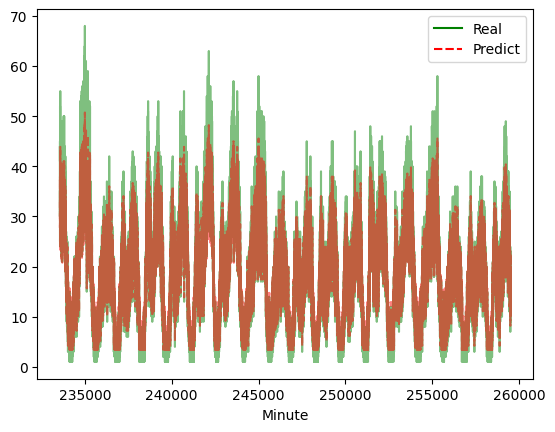

In [ ]:
y_pred = scaler.inverse_transform(np.concatenate((y_train, predicts)))
y_real = data['Next Request']

graph = pd.DataFrame({'Real': y_real, "Predict": y_pred.reshape(-1,)})
graph = graph.loc[graph.index > len(y_train)]
sns.lineplot(graph[["Real", "Predict"]], palette=['green', 'red'], alpha=0.5)

*  É perceptível que a medida que as previsões encaminham, a margem de erro aumenta, o que é uma característica normal. Para uma análise mais apropriada, basta pegar a previsão dos últimos dias.

<Axes: xlabel='Minute'>

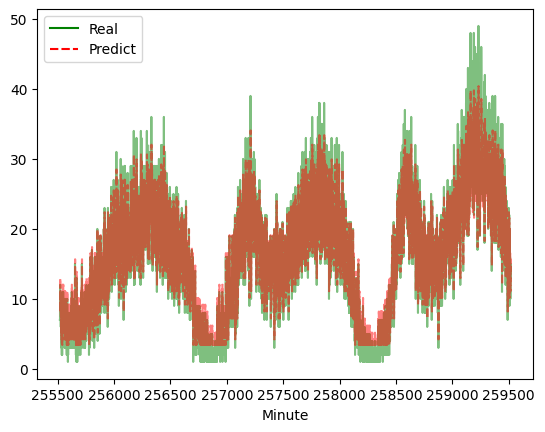

In [ ]:
sns.lineplot(graph[["Real", "Predict"]].loc[graph.index > len(y_real)-4000], palette=['green', 'red'], alpha=0.5)

*  Ou então mais detalhada ainda, uma análise dos últimos minutos.

<Axes: xlabel='Minute'>

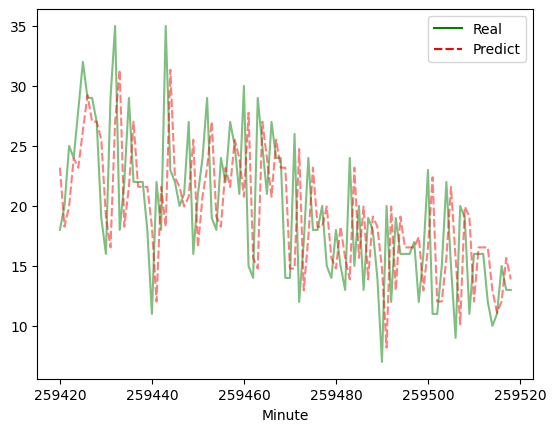

In [ ]:
sns.lineplot(graph[["Real", "Predict"]].loc[graph.index > len(y_real)-100], palette=['green', 'red'], alpha=0.5)

In [ ]:
errors = y_real - y_pred
absmean = abs(errors).mean()
var = np.var(errors)
print(f'Erro Absoluto: {absmean:.4} \nVariância: {var:.4}')

Erro Absoluto: 4.579 
Variância: 35.44


*  Considerando que o modelo não conhece as amostras de teste, é possível prever a quantidade de ubers que serão pedidos pelo tempo.

In [ ]:
print(f"Previsão da quantidade de pedidos de Uber em Nova York para daqui exatamente 1 dia, 19 horas e 32 minutos: {int(y_pred[2612])} +/- {int(absmean)}")
print(f"Amostragem da quantidade de pedidos de Uber em Nova York para daqui exatamente 1 dia, 19 horas e 32 minutos: {int(y_real[2612])}")

Previsão da quantidade de pedidos de Uber em Nova York para daqui exatamente 1 dia, 19 horas e 32 minutos: 17 +/- 4
Amostragem da quantidade de pedidos de Uber em Nova York para daqui exatamente 1 dia, 19 horas e 32 minutos: 18
